# Flower image recognition by Keras multiclass classification

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dropout, Flatten, RandomFlip, RandomRotation
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split, GridSearchCV

In [4]:
print(tf.__version__)
print(tf.keras.__version__)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2.6.0
2.6.0


## Credits

----
* Credits to the following resources which inspired and educated me 
    * Special Thanks to **Caroline S.**  for consulting and tips
    * Tensorflow callbacks documentation [Documentation link](https://www.tensorflow.org/guide/keras/custom_callback)
    * Tensorflow image processing documentation [Documentation link](https://www.tensorflow.org/tutorials/images/data_augmentation)
    * Modeling using Imagenet pretrained model [Robert Border](https://www.kaggle.com/rborder/tpu-flower-classification?kernelSessionId=78320658)[, Umar Farooq](https://medium.com/@imUmarFarooq/computer-vision-petals-to-the-metal-3465d66ad343)
    * Learning rate scheduler and callback functions [Bachr Chi](https://medium.com/@bechr7/learning-rate-scheduling-with-callbacks-in-tensorflow-e2ba83647013) [Udacity PyTordh Chllengers](https://medium.com/udacity-pytorch-challengers/ideas-on-how-to-fine-tune-a-pre-trained-model-in-pytorch-184c47185a20)
---

In [5]:
#load the EDA.py to retrieve constant and load train and test datasets
import autoreload
%load_ext autoreload
%autoreload 2

import EDA as eda

2.6.0
2.6.0
REPLICAS:  1


In [6]:
#detect tensor processing unit (TPU) and return the appropriate distribution strategy
strategy= eda.tpu_detect()

REPLICAS:  1


## Retrieve the constants from EDA.py
* `CLASS`: a list of 400 names of flowers with the index corresponding to the image labels
* `PATH`: local parent path for test/train/val dataset
* `TRAIN_FILES`: path associated with all files(labelled) in train data folder
* `VAL_FILES`: path associated with all files(labelled) in val data folder
* `TEST_FILES`: path associated with all files (unlabelled but with ID number) in test data folder

In [7]:
# CONSTANTS

#Class of flowers
CLASS=eda.CLASS
print(f'The first 5 class of flower names: {CLASS[:5]}')

#File paths
path=eda.PATH
train_files=eda.TRAIN_FILES
test_files=eda.TEST_FILES
val_files=eda.VAL_FILES

#image size
image_size=eda.IMAGE_SIZE

#bath_size optimized with the stragety
batch_size=eda.BATCH_SIZE

#assign a random seed
seed=42
AUTO=eda.AUTO

The first 5 class of flower names: ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'wild geranium']


## Load train, val and test data

In [61]:
#transform into train, val and test data
train = eda.get_training_dataset(eda.load_dataset(train_files))

#get train dataset with repeat() only for schedule learning rate model
train_lr=eda.get_training_dataset_lr(eda.load_dataset(train_files))
val = eda.get_validation_dataset(eda.load_dataset(val_files))
test = eda.get_test_dataset(ordered=True)


[autoreload of google.protobuf.any_pb2 failed: Traceback (most recent call last):
  File "C:\Users\eriya\anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\eriya\anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "C:\Users\eriya\anaconda3\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "C:\Users\eriya\anaconda3\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 783, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "C:\Users\eriya\anaconda3\lib\site-packages\google\protobuf\any_pb2.py", line 22, in <module>
    Any = _reflection.GeneratedProtocolMessageType('Any', (_message.Message,), {
TypeError: A Mess

## Check the shape of image and label datasets for train, val and test

In [9]:
eda.check_image_label_shape(train)

The data shapes:
(16, 224, 224, 3) (16,)
The data label examples: [47 14 88 ... 30 71 70]


In [10]:
eda.check_test_shape(test)

Test data shapes:
(16, 224, 224, 3) (16,)
Test data IDs: ['252d840db' 'dfd946ac8' '0c3ae4377' ... '630ba700c' 'b57dfb28a' '22149c3fd']


In [11]:
STEPS_PER_EPOCH=eda.get_steps_per_epochs()

797


## Print the images in the dataset as an example

(16, 224, 224, 3) (16,)


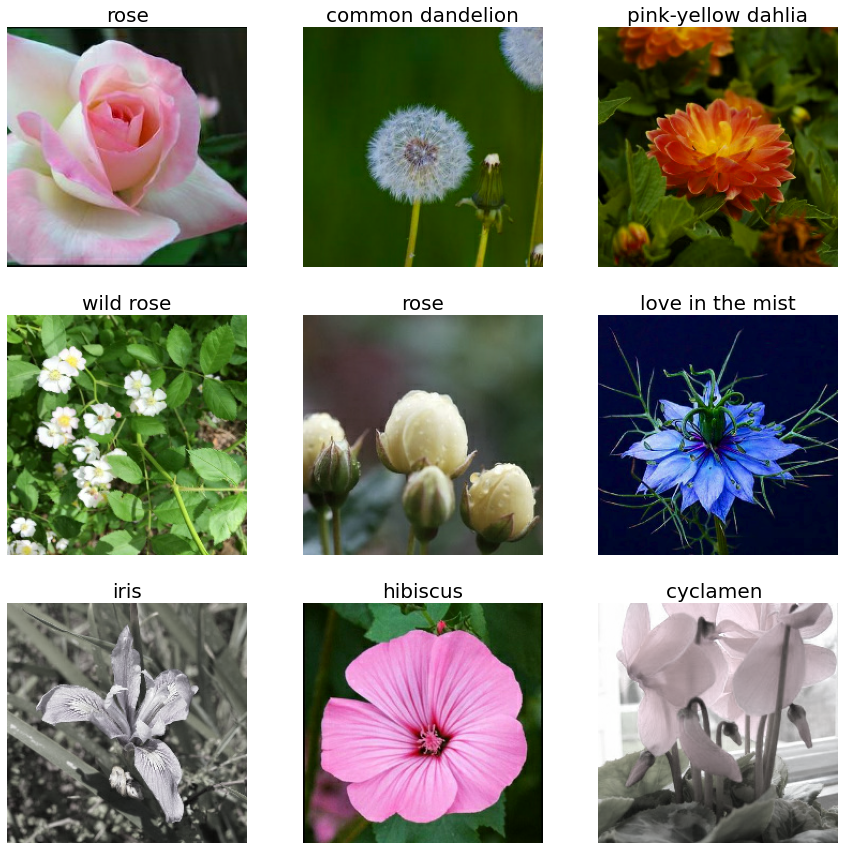

In [12]:
#show the image and the class name from train dataset, and photos with random augmentation is also showed (different contrast and saturation)
plt.figure(figsize=(15, 15))
for images, labels in train.take(1):
    print(images.shape, labels.shape)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(CLASS[labels[i]], fontsize=20)
        plt.axis("off");

## 1. CNN model
* model 1: Conv2D + Maxpooling (3 layers) with default 'adam'optimizer
* model 2: Conv2D + Maxpooling (3 layers) + Dropout layer with default 'adam'optimizer

### 1.1 Model 1: Conv2D + Maxpooling

In [13]:
#conv2d model

def conv2d_model(first_layer_neurons=32, second_layer_neurons=16, hidden_layers=5):
    #model
    model=Sequential()

    #conv 2d + pooling
    for layer in range(hidden_layers):
        if layer == 0:
            model.add(Conv2D(filters=first_layer_neurons, kernel_size=3, activation='relu', input_shape=(image_size[0], image_size[1], 3)))
            model.add(MaxPooling2D(pool_size=(2,2)))
        #conv2d + pooling
        else:
            model.add(Conv2D(filters=second_layer_neurons, kernel_size=3, activation='relu'))
            model.add(MaxPooling2D(pool_size=(2,2)))

    #flatten and dense
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    
    #output
    model.add(Dense(len(CLASS), activation='softmax'))
    
    #compile
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    
    return model

In [14]:
#instantiate the model
cnn=conv2d_model(hidden_layers=3)

In [15]:
#fit the model
results=cnn.fit(train,validation_data=val, epochs=6)

Epoch 1/6
798/798 [==============================] - 402s 502ms/step - loss: 3.8719 - sparse_categorical_accuracy: 0.1100 - val_loss: 3.3559 - val_sparse_categorical_accuracy: 0.1810
Epoch 2/6
798/798 [==============================] - 382s 479ms/step - loss: 3.3079 - sparse_categorical_accuracy: 0.1892 - val_loss: 3.0874 - val_sparse_categorical_accuracy: 0.2201
Epoch 3/6
798/798 [==============================] - 339s 425ms/step - loss: 2.9004 - sparse_categorical_accuracy: 0.2657 - val_loss: 3.0115 - val_sparse_categorical_accuracy: 0.2376
Epoch 4/6
798/798 [==============================] - 319s 400ms/step - loss: 2.4447 - sparse_categorical_accuracy: 0.3614 - val_loss: 3.1406 - val_sparse_categorical_accuracy: 0.2505
Epoch 5/6
798/798 [==============================] - 350s 439ms/step - loss: 1.9492 - sparse_categorical_accuracy: 0.4767 - val_loss: 3.4407 - val_sparse_categorical_accuracy: 0.2452
Epoch 6/6
798/798 [==============================] - 394s 494ms/step - loss: 1.4501 -

### Plot the accuracy of train and val datasets as a function of epochs

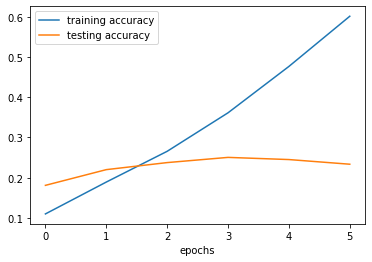

In [16]:
eda.plot_accuracy(results)
plt.savefig('./saved_img/accuracy_conv2d.jpeg')

### 1.2 Model 2: Conv2D + Maxpooling + Dropout

In [17]:
def conv2d_drop_model(first_layer_neurons=32, second_layer_neurons=16, drop_rate=0.5, hidden_layers=5):
    
    #model
    model=Sequential()

    #conv 2d + pooling
    for layer in range(hidden_layers):
        if layer == 0:
            model.add(Conv2D(filters=first_layer_neurons, kernel_size=3, activation='relu', input_shape=(image_size[0], image_size[1], 3)))
            model.add(MaxPooling2D(pool_size=(2,2)))
            model.add(Dropout(drop_rate))
        #conv2d + pooling
        else:
            model.add(Conv2D(filters=second_layer_neurons, kernel_size=3, activation='relu'))
            model.add(MaxPooling2D(pool_size=(2,2)))
            model.add(Dropout(drop_rate))

    #flatten and dense
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    
    #output
    model.add(Dense(len(CLASS), activation='softmax'))
    
    #compile
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    
    return model

In [18]:
#instantiate the model
cnn_drop=conv2d_drop_model(hidden_layers=3)

In [19]:
#fit the model
drop_results=cnn_drop.fit(train, validation_data=val, epochs=6)

Epoch 1/6
798/798 [==============================] - 426s 534ms/step - loss: 4.0103 - sparse_categorical_accuracy: 0.0852 - val_loss: 3.8997 - val_sparse_categorical_accuracy: 0.1331
Epoch 2/6
798/798 [==============================] - 362s 454ms/step - loss: 3.5465 - sparse_categorical_accuracy: 0.1451 - val_loss: 3.5280 - val_sparse_categorical_accuracy: 0.1751
Epoch 3/6
798/798 [==============================] - 358s 448ms/step - loss: 3.3426 - sparse_categorical_accuracy: 0.1742 - val_loss: 3.3110 - val_sparse_categorical_accuracy: 0.2034
Epoch 4/6
798/798 [==============================] - 358s 448ms/step - loss: 3.2381 - sparse_categorical_accuracy: 0.1898 - val_loss: 3.3474 - val_sparse_categorical_accuracy: 0.1864
Epoch 5/6
798/798 [==============================] - 352s 441ms/step - loss: 3.1464 - sparse_categorical_accuracy: 0.2037 - val_loss: 3.3004 - val_sparse_categorical_accuracy: 0.2185
Epoch 6/6
798/798 [==============================] - 352s 442ms/step - loss: 3.0730 -

### Plot the accuracy of train and val datasets as a function of epochs

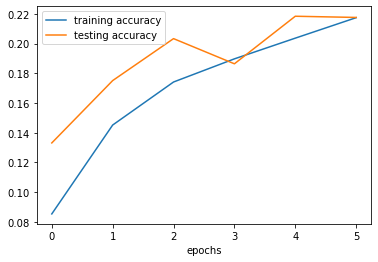

In [21]:
eda.plot_accuracy(drop_results)
plt.savefig('./saved_img/accuracy_conv2ddrop.jpeg')

## 2. Imagenet pretrained model + GlobalAveragePooling2D model

* create a function to define a time-based decay learning rate scheduler
* instantiate a pretrained Imagenet model
* instantiate a model to include the pretrained-model and a GlobalAveragePooling model
* fit the model with a learning rate scheduler

In [34]:
#!mkdir -p saved_img

#define a function to show image of prediction in validation dataset
def show_image(take_num, val_prediction):
    plt.figure(figsize=(12, 12))
    for images, labels in val.take(take_num):
        print(images.shape, labels.shape)
        for i in range(12):
            ax = plt.subplot(3, 4, i + 1)
            plt.imshow(images[i].numpy())
            #if the prediction matches with the val label, confirm it is okay
            if labels[i]==val_prediction[(take_num-1)*16+i]:
                confirmation='(Y)'
            #otherwise, assign the prediction as incorrect
            else:
                confirmation='(N)'
            plt.title(CLASS[val_prediction[(take_num-1)*16+i]]+confirmation, fontsize=18)
            plt.axis("off");
    #plt.savefig(f'./saved_img/validation_img_{take_num-1}.jpeg')

### Define a learning rate schedule to decay the learning rate as epoch increases

Learning rate schedule: 0.001 to 0.001, 0.001 


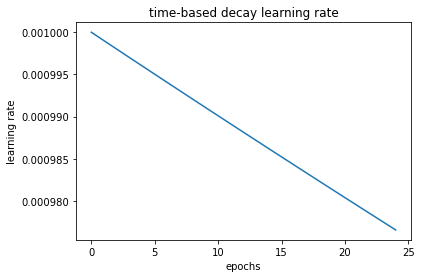

In [98]:
#define a time-based decay for learning schedule function

#initialize the learning rate and decay 
lr=0.01
epochs=10
decay=lr/epochs

#define the learning rate schedule function to return a slower learning rate as epoch increases
def lr_schedule_decay(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    return lr*1/(1+decay*epoch)

rng = [i for i in range(25)]
y = [lr_schedule_decay(x, 0.001) for x in rng]
plt.plot(rng, y)
plt.xlabel('epochs')
plt.title('time-based decay learning rate')
plt.ylabel('learning rate')
print(f'Learning rate schedule: {y[0]} to {max(y)}, {round(y[-1], 4)} ')
plt.savefig('./saved_img/time_lr.jpeg')

### Instantiate a Imagenet pre-trained model and combined with GlobalAveragePooling2D layers

Keras has a collection of pretrained models suitable for deep learning such as VGG16, ResNet, EfficientNet, DenseNet, etc. [link](https://keras.io/api/applications/).

We here chose `tensorflow.keras.applications.xception.Xception` for its relatively high accuracy and smaller in size comparing with others.

In [51]:
#Instantiate a globalaveragepooling2d model

with strategy.scope():
    pretrained_model = tf.keras.applications.xception.Xception(
        weights='imagenet',
        include_top=False , #do not include the first layer
        input_shape=[*image_size, 3]
    )
    pretrained_model.trainable = False #make sure model params in the imagenet is not trianable as it is pretrained
    
    model_2 = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASS), activation='softmax')
    ])

model_2.compile(
optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['sparse_categorical_accuracy'],
)

model_2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 104)               213096    
Total params: 21,074,576
Trainable params: 213,096
Non-trainable params: 20,861,480
_________________________________________________________________


## Fit the model

In [52]:
#time-based decay model 

history2 = model_2.fit(
    train_lr,
    validation_data=val,
    epochs=6,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=tf.keras.callbacks.LearningRateScheduler(lr_schedule_decay, verbose=1)
)

Epoch 1/6

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
797/797 [==============================] - 1381s 2s/step - loss: 1.9710 - sparse_categorical_accuracy: 0.5364 - val_loss: 1.2714 - val_sparse_categorical_accuracy: 0.6735
Epoch 2/6

Epoch 00002: LearningRateScheduler setting learning rate to 0.0009990010464510004.
797/797 [==============================] - 1367s 2s/step - loss: 1.1153 - sparse_categorical_accuracy: 0.7091 - val_loss: 1.0919 - val_sparse_categorical_accuracy: 0.7236
Epoch 3/6

Epoch 00003: LearningRateScheduler setting learning rate to 0.0009970070734739065.
797/797 [==============================] - 1372s 2s/step - loss: 0.9083 - sparse_categorical_accuracy: 0.7574 - val_loss: 0.9829 - val_sparse_categorical_accuracy: 0.7516
Epoch 4/6

Epoch 00004: LearningRateScheduler setting learning rate to 0.0009940250508360944.
797/797 [==============================] - 1367s 2s/step - loss: 0.7723 - sparse_categorical_accuracy: 0.7939 -

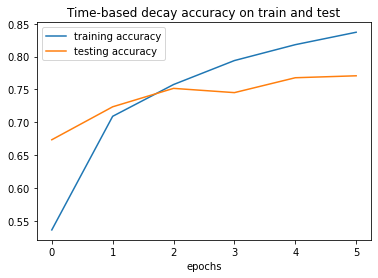

In [102]:
#plot the accuracy
eda.plot_accuracy(history2)
plt.title('Time-based decay accuracy on train and test')
plt.savefig('./saved_img/model_2_accuracy.jpeg')

### Observation: 
* Model is overpredicted after 2 epochs; however, the overal accuracy on testing is much higher than CNN and CNN_drop
* Testing accuracy reachs 77% after 5 epochs, and showed a slow increase or stable value, more epochs will not benefit us a more accurate model but became further overfitted.

## Make prediction on validation dataset

In [55]:
#get the probabilities
val_probability=model_2.predict(val)

#assign the prediction with the max probability
val_prediction=np.argmax(val_probability, axis=1)

(16, 224, 224, 3) (16,)


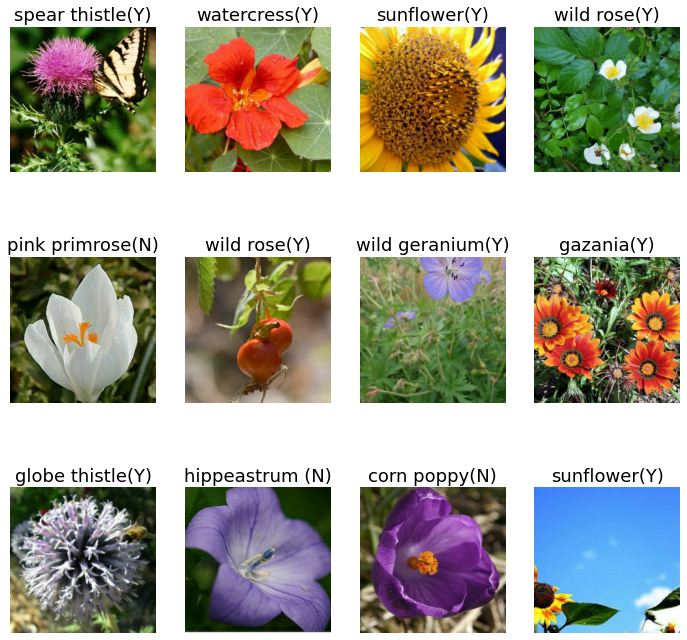

In [21]:
#show prediction and plot image
#if the prediction is correct, shown as flower_name(Y); otherwise, label as flower_name(N)
show_image(1, val_prediction)

## Make prediction on test dataset

In [39]:
#define a function to show image for unlabelled test dataset
def get_test_image(take_num, prediction):
    plt.figure(figsize=(12, 12))
    for images, labels in test.take(take_num):
        print(images.shape, labels.shape)
        for i in range(12):
            ax = plt.subplot(3, 4, i + 1)
            plt.imshow(images[i].numpy())
            #if the prediction matches with the val label, confirm it is okay
            plt.title(CLASS[prediction[(take_num-1)*16+i]], fontsize=18)
            plt.axis("off");

In [62]:
#get the probability array of the 104 classes for the test datasets 
test_proba=model_2.predict(test)

In [63]:
#assign the prediction of the class with the max probability
prediction=np.argmax(test_proba, axis=-1)

(16, 224, 224, 3) (16,)
(16, 224, 224, 3) (16,)
(16, 224, 224, 3) (16,)


<ipython-input-39-a9d1c9e298a1>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(3, 4, i + 1)


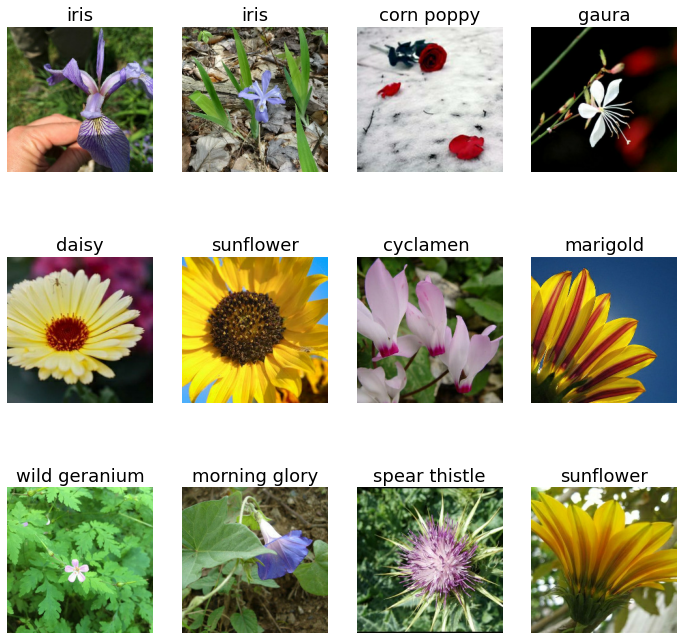

In [69]:
get_test_image(3, prediction)
plt.savefig('./saved_img/test_3_modeltime.jpeg')

## Define a decay function for step-decay

Learning rate schedule: 0.1 to 0.1, 0.025 


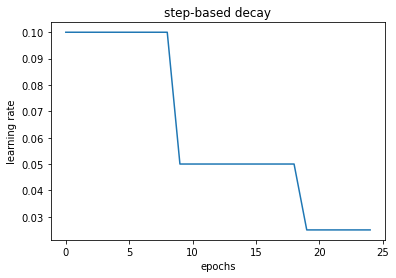

In [97]:
import math
def step_decay(epoch):
   initial_lrate = 0.1
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

rng = [i for i in range(25)]
y = [step_decay(x) for x in rng]
plt.plot(rng, y)
plt.title('step-based decay')
plt.xlabel('epochs')
plt.ylabel('learning rate')
print(f'Learning rate schedule: {y[0]} to {max(y)}, {round(y[-1], 4)} ')
#plt.savefig('./saved_img/step_lr.jpeg')

In [28]:
#Instantiate a globalaveragepooling2d model

with strategy.scope():
    pretrained_model = tf.keras.applications.xception.Xception(
        weights='imagenet',
        include_top=False , #do not include the first layer
        input_shape=[*image_size, 3]
    )
    pretrained_model.trainable = False #make sure model params in the imagenet is not trianable as it is pretrained
    
    model_step = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASS), activation='softmax')
    ])

model_step.compile(
optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['sparse_categorical_accuracy'],
)

model_step.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 104)               213096    
Total params: 21,074,576
Trainable params: 213,096
Non-trainable params: 20,861,480
_________________________________________________________________


In [30]:
#Fit time-based decay model 
history_step = model_step.fit(
    train_lr,
    validation_data=val,
    epochs=15,
    steps_per_epoch=STEPS_PER_EPOCH/2,
    callbacks=lrate
)

Epoch 1/15
398/398 [==============================] - 829s 2s/step - loss: 26.7343 - sparse_categorical_accuracy: 0.4524 - val_loss: 29.0947 - val_sparse_categorical_accuracy: 0.4857
Epoch 2/15
398/398 [==============================] - 822s 2s/step - loss: 27.0870 - sparse_categorical_accuracy: 0.5262 - val_loss: 19.7918 - val_sparse_categorical_accuracy: 0.6059
Epoch 3/15
398/398 [==============================] - 821s 2s/step - loss: 23.2822 - sparse_categorical_accuracy: 0.5896 - val_loss: 22.8719 - val_sparse_categorical_accuracy: 0.6161
Epoch 4/15
398/398 [==============================] - 821s 2s/step - loss: 20.1302 - sparse_categorical_accuracy: 0.6377 - val_loss: 24.0949 - val_sparse_categorical_accuracy: 0.6317
Epoch 5/15
398/398 [==============================] - 775s 2s/step - loss: 19.7857 - sparse_categorical_accuracy: 0.6606 - val_loss: 25.6963 - val_sparse_categorical_accuracy: 0.6398
Epoch 6/15
398/398 [==============================] - 775s 2s/step - loss: 18.2276 - 

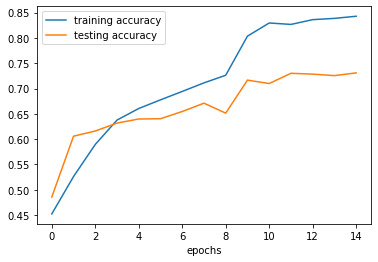

In [32]:
eda.plot_accuracy(history_step)
plt.savefig('./saved_img/step_decay_accuracy.jpeg')

**Step-decay learning rate:**
* The model has much longer compute time, less efficient. It started with a quick learning rate and getting slower as epochs increases.
* It requires more epochs to get to comparable testing accuracy as compared to the time-based decay model.
* After 14 epochs, the testing accuracy tends to reach a plateau, in other words, more epochs will only lead to overfit and no much benefit on better accuracy.

## Make a prediction on validation data

In [33]:
val_proba_2=model_step.predict(val)
val_pred_2= np.argmax(val_proba_2, axis=1)

(16, 224, 224, 3) (16,)
(16, 224, 224, 3) (16,)
(16, 224, 224, 3) (16,)


<ipython-input-34-108a55fe5b03>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(3, 4, i + 1)


(16, 224, 224, 3) (16,)
(16, 224, 224, 3) (16,)
(16, 224, 224, 3) (16,)
(16, 224, 224, 3) (16,)
(16, 224, 224, 3) (16,)
(16, 224, 224, 3) (16,)
(16, 224, 224, 3) (16,)


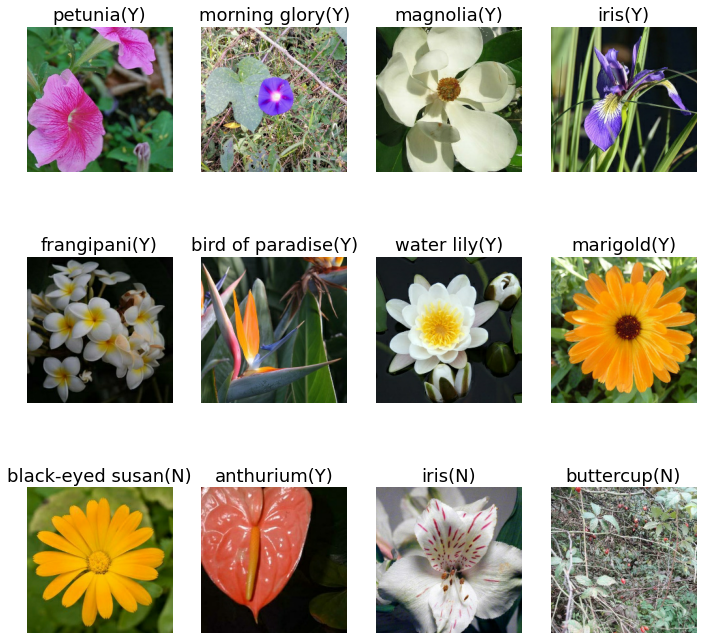

In [45]:
show_image(10, val_pred_2)
#plt.savefig('./saved_img/step_decay_val_10.jpeg')

## Make a prediction on test dataset(unlabelled)

In [65]:
test_proba_2=model_step.predict(test)
prediction_2=np.argmax(test_proba_2, axis=-1)

In [72]:
prediction_combine=np.argmax((test_proba+test_proba_2)/2, axis=-1)

(16, 224, 224, 3) (16,)
(16, 224, 224, 3) (16,)


<ipython-input-39-a9d1c9e298a1>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(3, 4, i + 1)


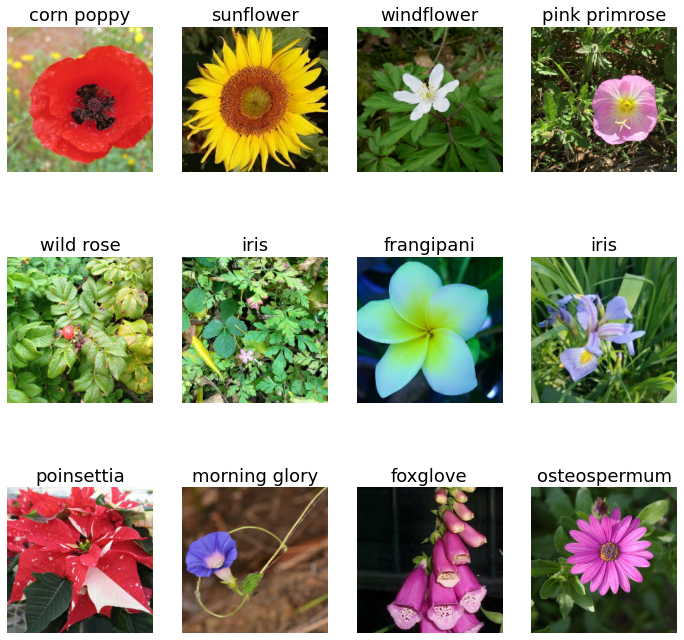

In [68]:
get_test_image(2, prediction_2)
#plt.savefig('./saved_img/test_2_modelstep.jpeg')

## Save the model

In [22]:
#create a path for model
#!mkdir -p saved_model

#save the model
model_2.save('saved_model/my_model_2')

INFO:tensorflow:Assets written to: saved_model/my_model_2\assets


C:\Users\eriya\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## Load the saved model and test if it can make prediction

In [70]:
#load the saved model
new_model = tf.keras.models.load_model('saved_model/my_model_2')

In [71]:
#just testing if the saved model can be used for prediction
new_model.predict(test)

array([[5.1686653e-05, 4.3300024e-06, 2.9112131e-04, ..., 8.7407088e-06,
        4.7885198e-05, 2.8202858e-06],
       [2.9012492e-07, 1.3348525e-11, 1.9432276e-09, ..., 2.0586557e-09,
        5.2347768e-06, 4.0843218e-09],
       [3.7954967e-03, 5.8374039e-06, 4.5426926e-03, ..., 1.5684729e-05,
        8.6255153e-05, 1.5466070e-01],
       ...,
       [1.0868973e-05, 3.2611113e-06, 3.9932279e-06, ..., 9.0250305e-06,
        1.0717209e-04, 9.0704780e-06],
       [3.0915112e-06, 1.2288363e-12, 2.9433592e-08, ..., 4.5820014e-09,
        4.4057958e-07, 3.4720661e-06],
       [3.6071308e-06, 6.5023904e-08, 1.8323892e-10, ..., 3.2472056e-10,
        3.4823766e-05, 4.6752470e-07]], dtype=float32)

Learning rate schedule: 0.0001 to 0.0005, 0.0001 


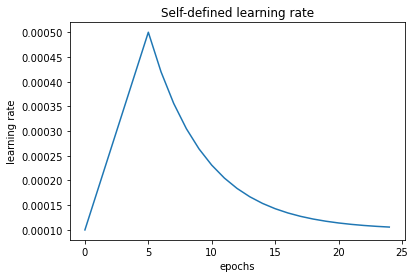

In [96]:
#custom LR scheduler
LR_START= 0.0001
LR_MAX = 0.0005 * strategy.num_replicas_in_sync
LR_MIN= 0.0001
LR_RAMPUP_EPOCHS=5
LR_SUSTAIN_EPOCHS=0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

lr_callback=tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

rng = [i for i in range(25)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
plt.title('Self-defined learning rate')
plt.xlabel('epochs')
plt.ylabel('learning rate')
print(f'Learning rate schedule: {y[0]} to {max(y)}, {round(y[-1], 4)} ')
plt.savefig('./saved_img/lrfn_lr.jpeg')

In [77]:
#make a directory to save the checkpoints
#%mkdir checkpoints

In [78]:
check_point=tf.keras.callbacks.ModelCheckpoint(filepath='./checkpoints',
                                              save_weights_only=True,
                                              monitor='val_f1_score',
                                              mode='max',
                                              save_best_only=True,
                                              verbose=1)

In [76]:
#Instantiate a globalaveragepooling2d model

with strategy.scope():
    pretrained_model = tf.keras.applications.xception.Xception(
        weights='imagenet',
        include_top=False , #do not include the first layer
        input_shape=[*image_size, 3]
    )
    pretrained_model.trainable = False #make sure model params in the imagenet is not trianable as it is pretrained
    
    model_lrfn = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASS), activation='softmax')
    ])

model_lrfn.compile(
optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['sparse_categorical_accuracy'],
)

model_lrfn.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 104)               213096    
Total params: 21,074,576
Trainable params: 213,096
Non-trainable params: 20,861,480
_________________________________________________________________


In [80]:
#fit the model with lrfn learning rate
history_lrfn=model_lrfn.fit(
    train_lr, 
    validation_data=val,
    epochs=25,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback, check_point])

Epoch 1/25

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
797/797 [==============================] - 1295s 2s/step - loss: 3.3961 - sparse_categorical_accuracy: 0.2604 - val_loss: 2.6878 - val_sparse_categorical_accuracy: 0.4100
Epoch 2/25

Epoch 00002: LearningRateScheduler setting learning rate to 0.00018.
797/797 [==============================] - 1298s 2s/step - loss: 2.2558 - sparse_categorical_accuracy: 0.4888 - val_loss: 1.8743 - val_sparse_categorical_accuracy: 0.5800
Epoch 3/25

Epoch 00003: LearningRateScheduler setting learning rate to 0.00026000000000000003.
797/797 [==============================] - 1265s 2s/step - loss: 1.6774 - sparse_categorical_accuracy: 0.6088 - val_loss: 1.4735 - val_sparse_categorical_accuracy: 0.6581
Epoch 4/25

Epoch 00004: LearningRateScheduler setting learning rate to 0.00034.
797/797 [==============================] - 1260s 2s/step - loss: 1.3456 - sparse_categorical_accuracy: 0.6775 - val_loss: 1.2534 - val_sparse_categor

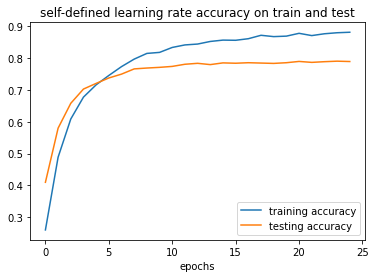

In [100]:
#plot the accuracy
eda.plot_accuracy(history_lrfn)
plt.title('self-defined learning rate accuracy on train and test')
plt.savefig('./saved_img/lrfn_accuracy.jpeg')

In [94]:
#save the model
model_lrfn.save('saved_model/my_model_lrfn')

INFO:tensorflow:Assets written to: saved_model/my_model_lrfn\assets


C:\Users\eriya\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [99]:
val_proba_lrfn=model_lrfn.predict(val)
val_pred_lrfn=np.argmax(val_proba_lrfn, axis=-1)

(16, 224, 224, 3) (16,)
(16, 224, 224, 3) (16,)
(16, 224, 224, 3) (16,)
(16, 224, 224, 3) (16,)


<ipython-input-34-108a55fe5b03>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(3, 4, i + 1)


(16, 224, 224, 3) (16,)


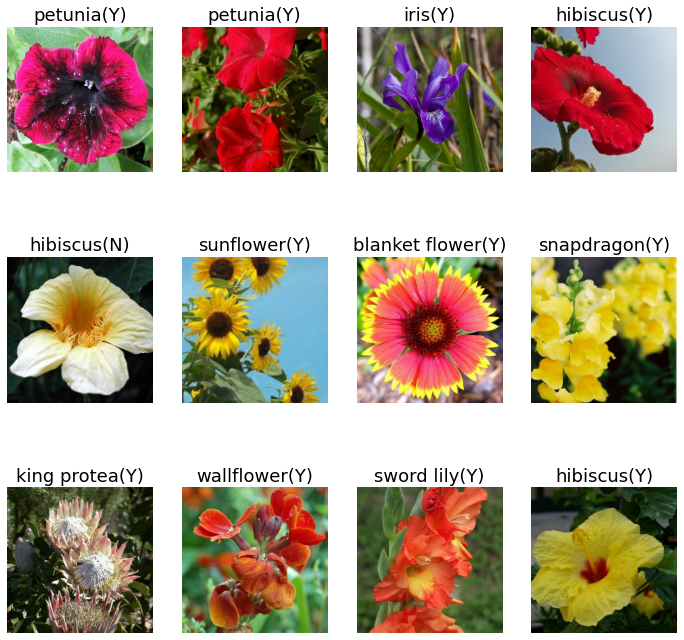

In [105]:
show_image(5,val_pred_lrfn)
plt.savefig('./saved_img/lrfn_val_take5.jpeg')

# Conclusions

* This Capstone demonstrated how to ultilize Tensor Processing Unit (TPU), a distribution strategy that TensowFlow specialized in deep learning tasks by using powerful TPU cores.
* CNN and pre-trained Xception models with self-defined learning rate schedulers were explored to construct deep learning model for multiclass classification. The best model in this project has 78% accuracy on validation dataset. 
    * The best model obtained in this project is pre-trained Xception model with AverageGlobalPooling2D layer model with self-defined learning rate, but the time-based decay learning rate is also as effective. The step-decay learning rate algorithm has slightly lower accuracy, and also it requires much longer time to fit the model (15 epochs).
  |-|      Time-based decay|        Self-defined learning decay|Conv2d+dropout|
  |---|---|---|---|
  |**Learning rate decay** |![](./saved_img/time_lr.jpeg)|![](./saved_img/lrfn_lr.jpeg)|*default in adam optimizer*|
  |**Accuracy plot**|![](./saved_img/model_2_accuracy.jpeg)|![](./saved_img/lrfn_accuracy.jpeg)|![](./saved_img/accuracy_conv2ddrop.jpeg)|
   
   
   
   
    * Without playing around with optimzer and learning rate, Conv2D without dropout layer has a tendency to overfit and the best testing accuracy is below 30%. Conv2D with dropout layer helped to control the overfit; however, the final model has low accuracy on both train and val datasets (<30%). Resources suggested that if we can play with the optmizer and learning rate, there is a chance we can improve the CNN model accuracy just as we can for Xception pretrain model.
    * It is, however, interesting to learn that there are fundamental difference between Global Aaverage Pooling and fully connected layer as in CNN.[resources]('https://codelabs.developers.google.com/codelabs/keras-flowers-tpu#11')
    
    ![](CNN_vs_GlobalAveragePooling.png)
   

